# LSTM Emulation of GR4J

In [1]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd

import sys
sys.path.append((Path(".").home() / "neuralhydrology").as_posix())
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from scripts.read_nh_results import (read_multi_experiment_results, calculate_member_errors)
from scripts.utils import get_data_dir
from neuralhydrology.utils.config import Config
import geopandas as gpd 

%load_ext autoreload
%autoreload 2

# Load Data

In [2]:
data_dir = get_data_dir()
run_dir = data_dir / "runs/hidden_size_GR4J/hs_008_1308_203557/"
run_dir = data_dir / "runs/hidden_size_GR4J/hs_064_1408_090417/"
run_dir = data_dir / "runs/hidden_size_GR4J/hs_002_1408_201225/"

# load config
cfg = Config(run_dir / "config.yml")
cfg.run_dir = run_dir

ens_dir = data_dir / "runs/hidden_size_GR4J"
preds = read_multi_experiment_results(ens_dir, ensemble_members=False)

Loading Ensemble Members: 9it [00:05,  1.60it/s]


In [3]:
# EPOCH = 30
# res_fp = get_test_filepath(run_dir, epoch=EPOCH)
# preds = get_all_station_ds(res_fp)

def member_to_hs(member: str) -> int:
    return int(member.split("hs_")[1].split("_")[0])


def assign_hs_to_ds(ds: xr.Dataset) -> xr.Dataset:
    return ds.assign_coords(hs=("member", [member_to_hs(m) for m in ds.member.values]))


preds = assign_hs_to_ds(preds)
preds["station_id"] = preds["station_id"].astype(int)

In [4]:
st_data_dir = Path(".").home() / "spatio_temporal/data"
static = xr.open_dataset(cfg.static_nc_file)
dynamic = xr.open_dataset(cfg.dynamic_nc_file)

shp_dir = data_dir / "CWATM/shapefile_ALL/"
shp = gpd.read_file(list(shp_dir.glob("*.shp"))[0])
shp.head()

,value,geometry
0,0.0,"POLYGON ((-3.32080 59.13348, -3.28650 59.13683..."
1,1.0,"POLYGON ((-3.31399 59.11586, -3.29685 59.11753..."
2,2.0,"POLYGON ((-3.13687 58.97768, -3.10270 58.98098..."
3,3.0,"POLYGON ((-3.39633 58.91574, -3.37929 58.91743..."
4,4.0,"POLYGON ((-6.32120 58.48228, -6.30450 58.48432..."


# Load model

In [5]:
# load trained model
EPOCH = 30
model = get_model(cfg).to(cfg.device)
_load_weights(model, cfg, epoch=EPOCH)
model

Using the model weights from /DataDrive200/data/runs/hidden_size_GR4J/hs_002_1408_201225/model_epoch030.pt


CudaLSTM(
  (embedding_net): InputLayer(
    (statics_embedding): Identity()
    (dynamics_embedding): Identity()
  )
  (lstm): LSTM(673, 2)
  (dropout): Dropout(p=0.4, inplace=False)
  (head): Regression(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=1, bias=True)
    )
  )
)

# Get training/test dataset

In [6]:
# ds = xr.open_dataset("/home/tommy/spatio_temporal/data/ALL_dynamic_ds.nc")
vars_ = cfg.dynamic_inputs + cfg.target_variables
ds = xr.open_dataset(cfg.dynamic_nc_file)[vars_]

def read_basin_list(txt_path: Path) -> pd.DataFrame:
    return pd.read_csv(txt_path, header=None).rename({0: "station_id"}, axis=1)


train_sids = read_basin_list(cfg.train_basin_file)
test_sids = read_basin_list(cfg.test_basin_file)
train_ds = ds.sel(time=slice(cfg.train_start_date, cfg.train_end_date), station_id=np.isin(ds.station_id, train_sids.station_id))
test_ds = ds.sel(time=slice(cfg.test_start_date, cfg.test_end_date), station_id=np.isin(ds.station_id, test_sids.station_id))

In [7]:
print((cfg.train_start_date, cfg.train_end_date))
print((cfg.test_start_date, cfg.test_end_date))

(Timestamp('1990-01-01 00:00:00'), Timestamp('2000-12-31 00:00:00'))
(Timestamp('2001-01-01 00:00:00'), Timestamp('2010-12-31 00:00:00'))


In [8]:
# test_ds.drop(["spatial_ref", "x", "y"])

### get camels

In [9]:
camels_run_dir = data_dir / "runs/ensemble_lstm"
camels_lstm_preds = xr.open_dataset(camels_run_dir / "results.nc")
# camels_errors = xr.open_dataset(camels_run_dir/ "mean_errors.nc")

if "camels_errors" not in globals():
    camels_errors = calculate_all_error_metrics(camels_lstm_preds, basin_coord="station_id", obs_var="discharge_spec_obs", sim_var="discharge_spec_sim", time_coord="time")
else:
    print("Already run errors!")
    
camels_errors["station_id"] = camels_errors["station_id"].astype(int)

Calculating Errors: 100%|███████████████████████████████████████████████████████████████████| 669/669 [01:52<00:00,  5.97it/s, 97002]


# Check the Performance of model

<xarray.Dataset>
Dimensions:     (station_id: 671, member: 9, time: 3652)
Coordinates:
  * station_id  (station_id) int64 10002 10003 1001 101002 ... 96002 96004 97002
  * time        (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2010-12-31
  * member      (member) <U18 'hs_002_1308_183739' ... 'hs_016_1508_075544'
    hs          (member) int64 2 8 128 4 256 64 2 32 16
Data variables:
    obs         (member, station_id, time) float32 5.205 4.454 ... 2.808 2.783
    sim         (member, station_id, time) float32 3.726 3.385 ... 2.773 2.737

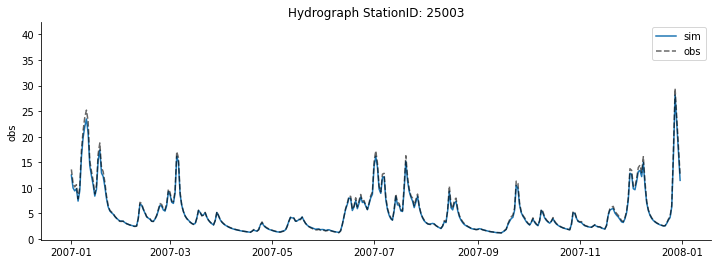

In [10]:
from scripts.plots import plot_hydrograph

time_dim = "time"
p = preds.isel(station_id=100).sel(member=preds["hs"] == 16).sel({time_dim: "2007"})

f, ax = plt.subplots(figsize=(12, 4))
plot_hydrograph(p, discharge_var="sim", precip_var=None, time_var=time_dim, basin_dim="station_id", ax=ax)
plot_hydrograph(p, discharge_var="obs", precip_var=None, time_var=time_dim, basin_dim="station_id", ax=ax, discharge_kwargs={"ls": "--", "alpha": 0.6, "color": "k"})
plt.legend()
sns.despine()

preds

In [11]:
error_path = ens_dir / "ALL_ERRORS.nc"
if not error_path.exists():
    errors = calculate_member_errors(preds, basin_coord="station_id", time_coord="time", obs_var="obs", sim_var="sim", metrics=["NSE"])
    errors.to_netcdf(error_path)
else:
    errors = xr.open_dataset(ens_dir / "ALL_ERRORS.nc")
errors["station_id"] = errors["station_id"].astype(int)

In [12]:
errors = assign_hs_to_ds(errors)
errors

<xarray.Dataset>
Dimensions:     (member: 9, station_id: 671)
Coordinates:
  * member      (member) object 'hs_002_1308_183739' ... 'hs_256_1408_055256'
  * station_id  (station_id) int64 10002 10003 1001 101002 ... 96002 96004 97002
    hs          (member) int64 2 2 4 8 16 32 64 128 256
Data variables:
    NSE         (member, station_id) float64 ...

In [13]:
# errors.sel(member=errors["hs"] == hs)

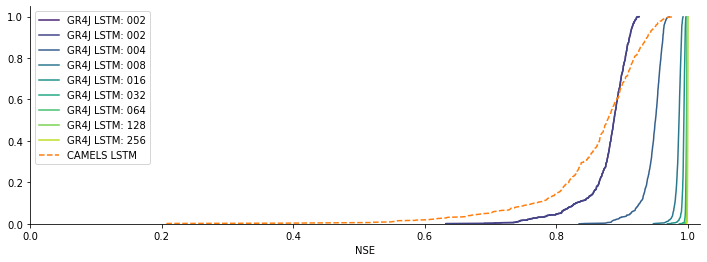

In [14]:
from typing import Any, Dict
import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(12, 4))

def empirical_cdf(errors: np.ndarray, ax: Any, kwargs: Dict[str, Any] = {}):
    x = np.sort(errors)
    y = np.arange(len(x))/float(len(x))
    ax.plot(x, y, **kwargs)

colors = sns.color_palette("viridis", len(errors["hs"]))
for ix, hs in enumerate(errors.hs):
    errors_plot = errors.sel(member=errors["hs"] == hs)["NSE"].values.flatten()
    # errors_plot = errors_plot.clip(0, 1)
    empirical_cdf(errors_plot, kwargs={f"label": f"GR4J LSTM: {int(hs):03}", "color": colors[ix]}, ax=ax)

ax.set_xlabel("NSE")
ax.set_xlim(0, None)
ax.set_ylim(0, None)
empirical_cdf(camels_errors["NSE"], kwargs={"color": "C1",  "label": "CAMELS LSTM", "ls": "--"}, ax=ax)
ax.legend()
sns.despine()

# Plot scatters

In [15]:
preds

<xarray.Dataset>
Dimensions:     (station_id: 671, member: 9, time: 3652)
Coordinates:
  * station_id  (station_id) int64 10002 10003 1001 101002 ... 96002 96004 97002
  * time        (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2010-12-31
  * member      (member) <U18 'hs_002_1308_183739' ... 'hs_016_1508_075544'
    hs          (member) int64 2 8 128 4 256 64 2 32 16
Data variables:
    obs         (member, station_id, time) float32 5.205 4.454 ... 2.808 2.783
    sim         (member, station_id, time) float32 3.726 3.385 ... 2.773 2.737

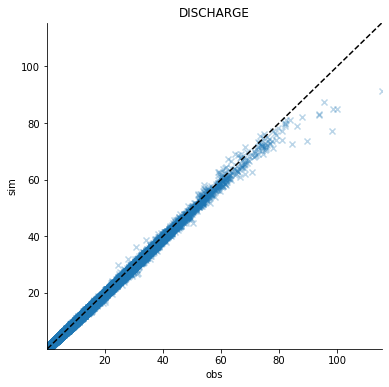

In [16]:
HS = 64
cam_ = camels_lstm_preds
preds_data = preds.sel(member=preds["hs"] == HS)

def scatter_plot(obs: np.ndarray, sim: np.ndarray, ax = None, scatter_kwargs: Dict = {"marker": "x", "color": "C0", "alpha": 0.3}):
    if ax is None:
        f, ax = plt.subplots(figsize=(6, 6))
    
    lim = (min([np.nanmin(obs), np.nanmin(sim)]), max([np.nanmax(obs), np.nanmax(sim)]))
    ax.scatter(obs, sim, **scatter_kwargs)
    ax.plot(lim, lim, ls="--", color="k")
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_xlabel("obs")
    ax.set_ylabel("sim")

    
epsilon = 1e-10
# x, y = np.log(cam_["obs"] + epsilon).values.flatten(), np.log(cam_["sim"] + epsilon).values.flatten()
# scatter_plot(obs=x, sim=y, scatter_kwargs={"marker": "x", "color": "C1", "alpha": 0.3})
# ax = plt.gca()

# big_preds = preds_data.copy().sel(station_id=big)
log = False
if log:
    x, y = np.log(preds_data["obs"] + epsilon).values.flatten(), np.log(preds_data["sim"] + epsilon).values.flatten()
else:
    x, y = preds_data["obs"].values.flatten(), preds_data["sim"].values.flatten()
scatter_plot(obs=x, sim=y)
ax = plt.gca()

ref_lines = False
if ref_lines:
    ax.axvline(3.7, color="k")
    ax.axvline(3.0, color="k")

ax.set_title(f"{'LOG ' if log else ''}DISCHARGE")
sns.despine()

# Visualise Hydrographs

In [17]:
preds.data_vars

Data variables:
    obs      (member, station_id, time) float32 5.205 4.454 ... 2.808 2.783
    sim      (member, station_id, time) float32 3.726 3.385 ... 2.773 2.737

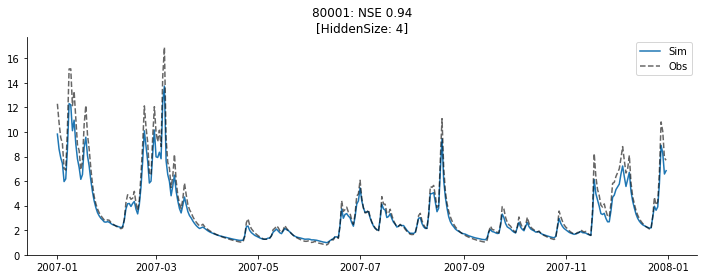

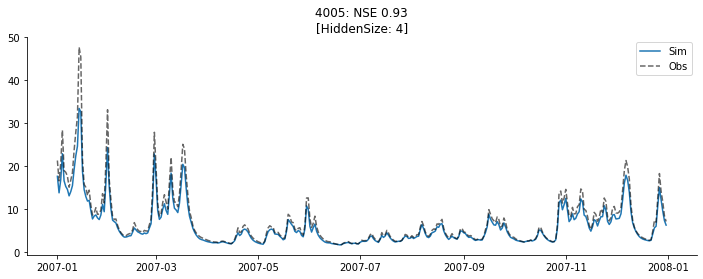

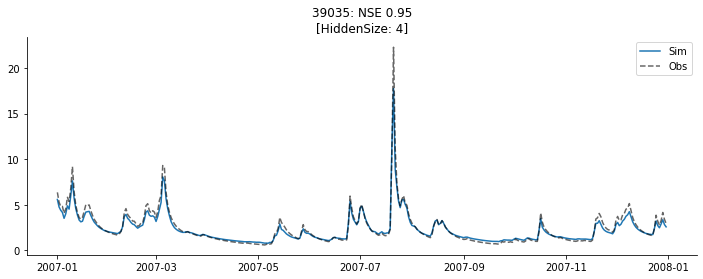

In [28]:
HS = 4
N = 3
time_dim = "time"

for _ in range(N):
    sid = np.random.choice(preds.station_id.values)
    data = preds.sel(station_id=sid, member=preds["hs"] == HS).sel({time_dim: "2007"})
    err = errors.sel(station_id=sid, member=errors["hs"] == HS)
    hs = int(data.hs.values)
    f, ax = plt.subplots(figsize=(12, 4))
    ax.plot(data[time_dim], data["sim"].values.ravel(), label="Sim")
    ax.plot(data[time_dim], data["obs"].values.ravel(), alpha=0.6, ls="--", color="k", label="Obs")
    ax.set_title(f"{sid}: NSE {float(err['NSE']):.2f}\n[HiddenSize: {hs}]")
    ax.legend()
    sns.despine()

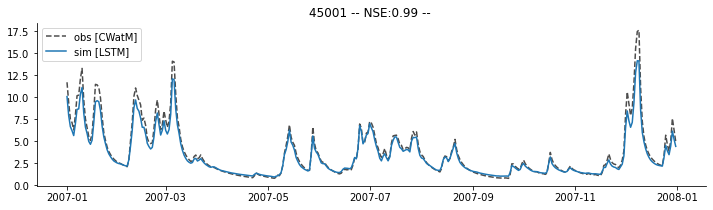

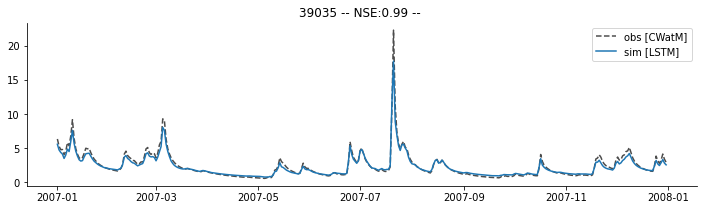

In [36]:
N = 2
for _ in range(N):
    px = np.random.choice(preds.station_id.values)
    p = preds.sel(time="2007", station_id=px).sel(member=preds["hs"]==HS)

    f, ax = plt.subplots(figsize=(12, 3))
    ax.plot(p["time"], p["obs"].values.ravel(), label="obs [CWatM]", color="k", ls="--", alpha=0.7)
    ax.plot(p["time"], p["sim"].values.ravel(), label="sim [LSTM]")
    
    err = float(errors.sel(station_id=px, member=preds["hs"]==HS).NSE.values)
    ax.set_title(f"{px} -- NSE:{err:.2f} -- ")
    sns.despine()
    ax.legend()


# Visualise Spatially

In [37]:
import geopandas as gpd
from scripts.geospatial import initialise_gb_spatial_plot, load_latlon_points
from mpl_toolkits.axes_grid1 import make_axes_locatable

st_data_dir = data_dir
points = load_latlon_points(st_data_dir)
errors["station_id"] = errors["station_id"].astype(int)
static = xr.open_dataset(st_data_dir / "camels_static.nc")

In [38]:
np.isin(errors["NSE"].to_dataframe().index, points.index)
gdf = gpd.GeoDataFrame(errors.to_dataframe().join(points))
gdf.head()

NSE  hs                   geometry
member             station_id                                         
hs_002_1308_183739 10002       0.897822   2  POINT (-1.83000 57.53000)
                   10003       0.893192   2  POINT (-2.09000 57.36000)
                   1001        0.873176   2  POINT (-3.27000 58.48000)
                   101002      0.911492   2  POINT (-1.29000 50.69000)
                   101005      0.925904   2  POINT (-1.25000 50.65000)

In [39]:
camels_gdf = gpd.GeoDataFrame(camels_errors.to_dataframe().join(points))

<AxesSubplot:>

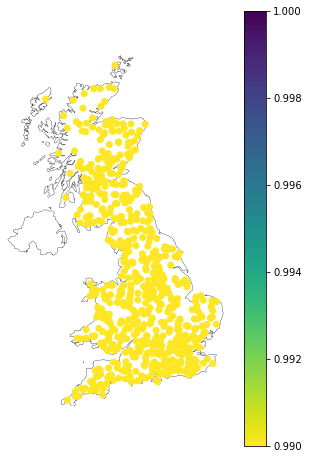

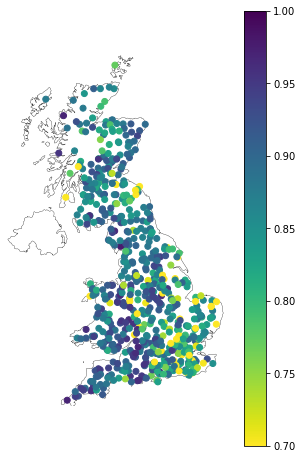

In [40]:
ax = initialise_gb_spatial_plot(data_dir=data_dir)
gdf.loc[gdf["hs"] == HS].plot("NSE", ax=ax, vmin=0.99, vmax=1, cmap="viridis_r", legend=True)

ax = initialise_gb_spatial_plot(data_dir=data_dir)
camels_gdf.plot("NSE", ax=ax, vmin=0.7, vmax=1, cmap="viridis_r", legend=True)

# Probe

In [41]:
assert False

AssertionError: 

In [42]:
PER_BASIN = False

## load cell state data

In [43]:
from scripts.cell_state.extract_cell_state import get_cell_states

out_dir = run_dir / "cell_states"
if not out_dir.exists():
    out_dir.mkdir(parents=True, exist_ok=True)

if not (out_dir / "cell_states.nc").exists():
    cn = get_cell_states(cfg, run_dir)
    cn.to_netcdf(out_dir / "cell_states.nc")
else:
    cn = xr.open_dataset(out_dir / "cell_states.nc")

In [44]:
from scripts.cell_state.cell_state_dataset import dataset_dimensions_to_variable

# New data
station_dim = "station_id"
time_dim = "date"

# normalize ???
mean_ = cn.mean(dim=[station_dim, time_dim])
std_ = cn.std(dim=[station_dim, time_dim])
norm_cs_data = (cn - mean_) / std_
# or per station-dimension
# norm_cs_data = 

cs = dataset_dimensions_to_variable(
    ds=norm_cs_data, 
    variable="c_n",
    dimension_to_convert_to_variable_dim="dimension",
    time_dim="date",
).rename({"date": "time"})
cs["station_id"] = cs["station_id"].astype(int)

In [45]:
cs

<xarray.Dataset>
Dimensions:     (time: 3652, station_id: 671)
Coordinates:
  * time        (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2010-12-31
  * station_id  (station_id) int64 10002 10003 1001 101002 ... 96002 96004 97002
Data variables:
    dim0        (time, station_id) float32 0.7968 1.074 1.126 ... 0.911 0.3043
    dim1        (time, station_id) float32 -0.9896 -1.023 ... -1.059 -0.7106

## create dataset for probe training

In [ ]:
from scripts.cell_state.sklearn_models import (
    init_linear_model,
    evaluate,
    create_analysis_dataset,
    fit_and_predict,
)
from scripts.cell_state.timeseries_dataset import TimeSeriesDataset, get_time_basin_aligned_dictionary
from collections import defaultdict

In [ ]:
from scripts.cell_state.normalize import normalize_2d_dataset

# TARGET_VARS = ["storGroundwater", "SnowCover", "sum_w1", "sum_w2", "sum_w3"]
# TARGET_VARS = ["storGroundwater", "sum_w1", "sum_w2", "sum_w3"]
TARGET_VARS = ["s_store", "r_store"]
target_ds = dynamic[TARGET_VARS].copy()

for var in target_ds.data_vars:
    target_ds[var] = normalize_2d_dataset(target_ds[[var]], variable_str=var, per_basin=PER_BASIN)

In [ ]:
print(cfg.test_start_date)
print(cfg.test_end_date)

In [ ]:
target_ds = target_ds.copy()
input_ds = cs

train_start_date: pd.Timestamp = input_ds.time.min()
train_end_date: pd.Timestamp = pd.to_datetime("2006-09-30")
test_start_date: pd.Timestamp = pd.to_datetime("2006-09-30")
test_end_date: pd.Timestamp =  input_ds.time.max()
seq_length = 1
basin_dim = "station_id"
time_dim = "time"
input_variables = [f"dim{i}" for i in np.arange(cn.dimension.size)]

# train test split
target_data = target_ds.sel(time=slice(train_start_date, train_end_date))
input_data = input_ds.sel(time=slice(train_start_date, train_end_date))

test_target_data = target_ds.sel(time=slice(test_start_date, test_end_date))
test_input_data = input_ds.sel(time=slice(test_start_date, test_end_date))


all_train_test = defaultdict(dict)
for target_var in [v for v in target_data.data_vars]:
    print(f"** STARTING {target_var} **")
    train_dataset = TimeSeriesDataset(
        input_data=input_data,
        target_data=target_data,
        target_variable=target_var,
        input_variables=input_variables,
        seq_length=seq_length,
        basin_dim=basin_dim,
        time_dim=time_dim,
        desc="Creating Train Samples",
    )

    train = get_time_basin_aligned_dictionary(train_dataset)

    test_dataset = TimeSeriesDataset(
        input_data=test_input_data,
        target_data=test_target_data,
        target_variable=target_var,
        input_variables=input_variables,
        seq_length=seq_length,
        basin_dim=basin_dim,
        time_dim=time_dim,
        desc="Creating Test Samples",
    )

    test = get_time_basin_aligned_dictionary(test_dataset)
    
    all_train_test[target_var]["train"] = train
    all_train_test[target_var]["test"] = test

## run the probe

In [ ]:
from scripts.cell_state.analysis import save_probe_components, load_probe_components

In [ ]:
# initalise the model 
all_models_preds = defaultdict(dict)
target_vars = [v for v in target_data.data_vars]

for target_var in [v for v in target_ds.data_vars]:
    print(f"** {target_var} **")
    _model, _preds, _errors = fit_and_predict(all_train_test[target_var]["train"], all_train_test[target_var]["test"], random_seed=100)
    all_models_preds[target_var]["model"] = _model
    all_models_preds[target_var]["preds"] = _preds
    all_models_preds[target_var]["errors"] = _errors

# all_models_preds = load_probe_components(run_dir=run_dir)

## Analysis

In [ ]:
f, ax = plt.subplots(figsize=(12, 4))

colors = sns.color_palette("viridis", n_colors=len(target_vars))
for ix, target_var in enumerate(target_vars):
    errors = all_models_preds[target_var]["errors"]
    nse = errors["NSE"]

    ax.hist(nse.where(nse > -1, -1), bins=100, density=True, label=f"{target_var}: {nse.median().values:.3f}", alpha=0.6, color=colors[ix]);
    ax.axvline(nse.median(), color=colors[ix], ls="--", alpha=0.5)
    

ax.set_xlim(-1, 1)
ax.legend()
sns.despine()

In [ ]:
p = all_models_preds[TARGET_VARS[0]]["preds"]
time = "2007"

N = 3
pixels = np.random.choice(p.station_id.values, N, replace=False)

for px in pixels:
    f, axs = plt.subplots(1, 2, figsize=(12, 2), sharex=True)
    for ix, target_var in enumerate(target_vars):
        ax = axs[np.unravel_index(ix, (3, 2)) if len(axs.shape) > 1 else ix]
        cs_preds = all_models_preds[target_var]["preds"]
        data = cs_preds.sel(station_id=px, time=time)

    #     f, ax = plt.subplots(figsize=(12, 4))
        ax.plot(data.time, data.obs, color="k", ls="--", alpha=0.3, label="Obs")
        ax.plot(data.time, data.sim, color=f"C{ix}", ls="-", alpha=0.6, label=f"{target_var}")
        ax.set_ylabel(px)
        ax.legend()
        sns.despine()

In [ ]:
all_ws_bs = np.empty((len(target_vars), cn.dimension.size))
all_ws_bs.shape

In [ ]:
# np.stack(w,  np.array(b))

In [ ]:
from scripts.cell_state.analysis import get_model_weights, plot_weights

n_plots = len(target_vars)
f, axs = plt.subplots(n_plots, 1, figsize=(12, 2*n_plots))


all_ws_bs = np.empty((len(target_vars), cn.dimension.size + 1))
for ix, target_var in enumerate(target_vars):
    model = all_models_preds[target_var]["model"]
    ax = axs[ix] if n_plots > 1 else axs
    w, b = get_model_weights(model)
    
    all_ws_bs[ix, :] = np.concatenate([w, np.array(b)])
    plot_weights(np.abs(w), kwargs={"vmin": 0.0, "vmax": 0.3}, ax=ax, cbar=False)
    ax.set_title(f"Target: {target_var}")
plt.tight_layout()

In [ ]:
im = plt.matshow(all_ws_bs[:, :-1], vmin=-0.6, vmax=0.6, cmap="RdBu_r")
plt.colorbar(im, label="Regression weight")
ax = plt.gca()
ax.set_yticklabels([0] + target_vars)
ax.set_xticklabels([0] + input_variables);

# Plot the raw cell states

In [ ]:
from scripts.utils import round_time_to_hour

In [ ]:
sid = 52005
time = "2007"
N = 3

for _ in range(N):
    sid = np.random.choice(cs_preds.station_id.values)
    f, axs = plt.subplots(2, 1, figsize=(12, 4))

    for ix, target_var in enumerate(TARGET_VARS):
        # get the data for that variable
        cs_preds = round_time_to_hour(all_models_preds[target_var]["preds"])
        cs_dims = input_ds.sel(time=cs_preds.time)

        ax = axs[ix]
        store_data = cs_preds["obs"].sel(station_id=sid).sel({time_dim: time})
        ax.plot(store_data.time, store_data, label="Obs", ls="--", alpha=0.7, color="k")
        for dim in cs_dims.data_vars:
            c_data = cs_dims[dim].sel(station_id=sid).sel({time_dim: time})
            ax.plot(c_data.time, c_data, label=dim)

        ax.set_title(target_var)
        ax.legend()


    sns.despine()
    plt.tight_layout()